In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../..")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from utils.evaluate_basset_performance import *
from utils.call_peaks import call_peaks
import pyranges as pr
from functools import partial

Compute additional accuracy metrics

## 1. False positives / false negatives

### Loeb et al.

In [3]:
data_dir = "/clusterfs/nilah/pooja/kidney_data"
fig_dir = "/clusterfs/nilah/pooja/CellTypeSpecificAccessibilityPrediction/figures"
clusters_dir = f"{data_dir}/CellTypeSpecificPeakClusters_ArchR_clust11"
targets_dir = f"{clusters_dir}/model_predictions"
models_dir = f"{data_dir}/train/replicate_models"

In [4]:
multitask_model = f"{models_dir}/train__multitask__all_sequences__1"
single_task_model = models_dir + "/train__single_task__{cell_type}__all_sequences__1"

targets = pd.read_csv(f"{data_dir}/targets.txt", sep="\t", header=0, index_col=0)
cell_types = targets["identifier"].values

cell_type_peak_set_mapping = {"PT": ["cluster11_PT", "cluster6_PanTubule", "cluster3_Ubiquitous"],
                             "DT": ["cluster4_DistalNephron", "cluster6_PanTubule", "cluster3_Ubiquitous"],
                             "LOH": ["cluster4_DistalNephron", "cluster6_PanTubule", "cluster3_Ubiquitous"],
                             "Str": ["cluster9_Stroma", "cluster8_PanNonEpithelial", "cluster3_Ubiquitous"]}

model_preds = {"Multi-task predictions": read_multi_task_targets_predictions(multitask_model, 
                                                                 targets_dir, ["all_sequences"], cell_types),
               "Single-task predictions": read_single_task_targets_predictions(single_task_model,
                                                                   targets_dir, ["all_sequences"],
                                                                    cell_type_peak_set_mapping.keys())}

In [5]:
# annotate prediction bins with peak types
all_sequences = pr.read_bed(f"{clusters_dir}/all_sequences_test_chrs.bed")
all_sequences = all_sequences.subsequence(start=576, end=768)
all_sequences.Index = all_sequences.df.index.values


for cell_type, clusters in cell_type_peak_set_mapping.items():
    for cluster in clusters:
        if cluster not in all_sequences.columns:
            cluster_peaks = pr.read_bed(f"{clusters_dir}/{cluster}_test_chrs.bed")
            cluster_col = np.zeros(len(all_sequences))
            cluster_peaks_overlap = all_sequences.overlap(cluster_peaks, how="containment").Index.values
            cluster_col[cluster_peaks_overlap] = 1
            setattr(all_sequences, cluster, cluster_col)
    setattr(all_sequences, f"{cell_type} Peaks", all_sequences.df[clusters].sum(axis=1) > 0)

all_peaks = pr.read_bed(f"{clusters_dir}/all_peaks.bed")
all_peaks_col = np.zeros(len(all_sequences))
all_peaks_overlap = all_sequences.overlap(all_peaks, how="containment").Index.values
all_peaks_col[all_peaks_overlap] = 1
setattr(all_sequences, "All peaks", all_peaks_col) 

all_sequences = all_sequences.df

In [6]:
# call peaks on predictions
for i, cell_type in enumerate(cell_type_peak_set_mapping.keys()):
    for j, tasks in enumerate(["Multi-task", "Single-task"]):
        targets = model_preds[f"{tasks} predictions"]["all_sequences"][f"{cell_type}_pred"].values
        targets_peaks = call_peaks(targets.reshape(-1,1), return_full=True, fdr=0.05).flatten()
        all_sequences[f"{tasks} {cell_type} predicted Peaks"] = targets_peaks

In [7]:
error_df = compute_false_positive_false_negative_error_rates(all_sequences, cell_type_peak_set_mapping, "cluster3_Ubiquitous")

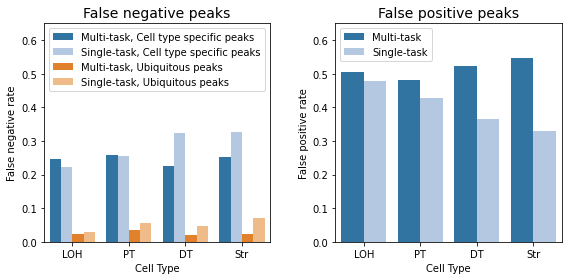

In [92]:
cmap = plt.get_cmap("tab20")
fig, ax = plt.subplots(1, 2, figsize=(8,4))

sns.barplot(data=error_df[~error_df["Cluster"].isin(["All sequences", "All peaks", "cluster6_PanTubule", "cluster8_PanNonEpithelial"])], 
            x="Cell Type", y="False negative rate", hue="Tasks",
            hue_order=["Multi-task, Cell type specific peaks", "Single-task, Cell type specific peaks",
                       "Multi-task, Ubiquitous peaks", "Single-task, Ubiquitous peaks"],
            palette="tab20", order=["LOH", "PT", "DT", "Str"], ax=ax[0])


ax[0].legend(loc="upper left")
ax[0].set_ylabel("False negative rate")
ax[0].set_title("False negative peaks", fontsize=14)
ax[0].set_ylim(0, 0.65)

cluster = "All peaks"
sns.barplot(data=error_df[error_df["Cluster"] == cluster], x="Cell Type", y="False positive rate", hue="Tasks",
            palette=[cmap(0), cmap(1)], order=["LOH", "PT", "DT", "Str"], ax=ax[1])
ax[1].set_title("False positive peaks", fontsize=14)
ax[1].legend(loc="upper left")
ax[1].set_ylim(0, 0.65)

plt.tight_layout()
plt.savefig(f"{fig_dir}/supp_figs/loeb_et_al_false_negatives_false_positives.pdf", dpi=300)

In [8]:
for peak_cell_type, other_cell_type in [("Str", "PT"), ("PT", "Str")]:
    sampled_seqs = all_sequences[(all_sequences[f"All peaks"] > 0) &
                  (all_sequences[f"{peak_cell_type} Peaks"]) &
                  (~all_sequences[f"{other_cell_type} Peaks"]) &
                  (all_sequences[f"Multi-task {peak_cell_type} predicted Peaks"]) &
                  (all_sequences[f"Single-task {peak_cell_type} predicted Peaks"]) &
                  (all_sequences[f"Multi-task {other_cell_type} predicted Peaks"]) &
                  (~all_sequences[f"Single-task {other_cell_type} predicted Peaks"])].sample(1000, replace=False)

    sampled_seqs[["Chromosome", "Start", "End", "Index"]].to_csv(
        f"{clusters_dir}/{peak_cell_type}_peaks_multitask_false_positive_in_{other_cell_type}_1000_seqs.bed",
        sep="\t", header=False, index=False)

### Calderon et al.

In [12]:
data_dir = "/clusterfs/nilah/pooja/immune_atlas"
fig_dir = "/clusterfs/nilah/pooja/CellTypeSpecificAccessibilityPrediction/figures"
clusters_dir = f"{data_dir}/CellTypeSpecificPeakClusters"
targets_dir = f"{clusters_dir}/model_predictions"
models_dir = f"{data_dir}/train/replicate_models"

In [13]:
multitask_model = f"{models_dir}/train__multitask__all_sequences__1"
single_task_model = models_dir + "/train__single_task__{cell_type}__all_sequences__1"

targets = pd.read_csv(f"{data_dir}/targets.txt", sep="\t", header=0, index_col=0)
cell_types = targets["identifier"].values

cell_type_peak_set_mapping = {"DCmye": ["cluster_myeloid_resting", "cluster_open"],
                             "NKim": ["cluster_nk_resting", "cluster_open"],
                             "TCD8EM": ["cluster_T_resting", "cluster_open"]}

model_preds = {"Multi-task predictions": read_multi_task_targets_predictions(multitask_model, 
                                                                 targets_dir, ["all_sequences"], cell_types),
               "Single-task predictions": read_single_task_targets_predictions(single_task_model,
                                                                   targets_dir, ["all_sequences"],
                                                                    cell_type_peak_set_mapping.keys())}

In [14]:
# annotate prediction bins with peak types
all_sequences = pr.read_bed(f"{clusters_dir}/all_sequences_test_chrs.bed")
all_sequences = all_sequences.subsequence(start=576, end=768)
all_sequences.Index = all_sequences.df.index.values


for cell_type, clusters in cell_type_peak_set_mapping.items():
    for cluster in clusters:
        if cluster not in all_sequences.columns:
            cluster_peaks = pr.read_bed(f"{clusters_dir}/{cluster}_test_chrs.bed")
            cluster_col = np.zeros(len(all_sequences))
            cluster_peaks_overlap = all_sequences.overlap(cluster_peaks, how="containment").Index.values
            cluster_col[cluster_peaks_overlap] = 1
            setattr(all_sequences, cluster, cluster_col)
    setattr(all_sequences, f"{cell_type} Peaks", all_sequences.df[clusters].sum(axis=1) > 0)

all_peaks = pr.read_bed(f"{clusters_dir}/immune_atlas_all_peaks.bed")
all_peaks_col = np.zeros(len(all_sequences))
all_peaks_overlap = all_sequences.overlap(all_peaks, how="containment").Index.values
all_peaks_col[all_peaks_overlap] = 1
setattr(all_sequences, "All peaks", all_peaks_col) 

all_sequences = all_sequences.df

In [15]:
# call peaks on predictions
for i, cell_type in enumerate(cell_type_peak_set_mapping.keys()):
    for j, tasks in enumerate(["Multi-task", "Single-task"]):
        targets = model_preds[f"{tasks} predictions"]["all_sequences"][f"{cell_type}_pred"].values
        targets_peaks = call_peaks(targets.reshape(-1,1), return_full=True, fdr=0.05).flatten()
        all_sequences[f"{tasks} {cell_type} predicted Peaks"] = targets_peaks

In [16]:
error_df = compute_false_positive_false_negative_error_rates(all_sequences, cell_type_peak_set_mapping, "cluster_open")

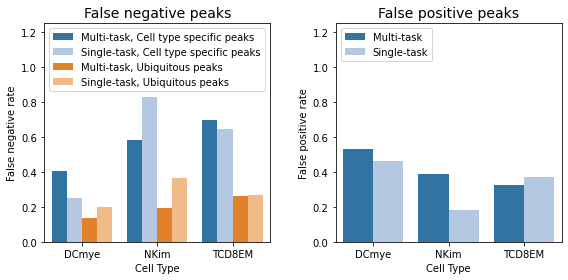

In [98]:
cmap = plt.get_cmap("tab20")
fig, ax = plt.subplots(1, 2, figsize=(8,4))

sns.barplot(data=error_df[~error_df["Cluster"].isin(["All sequences", "All peaks"])], 
            x="Cell Type", y="False negative rate", hue="Tasks",
            hue_order=["Multi-task, Cell type specific peaks", "Single-task, Cell type specific peaks",
                       "Multi-task, Ubiquitous peaks", "Single-task, Ubiquitous peaks"],
            palette="tab20", order=["DCmye", "NKim", "TCD8EM"], ax=ax[0])


ax[0].legend(loc="upper left")
ax[0].set_ylabel("False negative rate")
ax[0].set_title("False negative peaks", fontsize=14)
ax[0].set_ylim(0, 1.25)

cluster = "All peaks"
sns.barplot(data=error_df[error_df["Cluster"] == cluster], x="Cell Type", y="False positive rate", hue="Tasks",
            palette=[cmap(0), cmap(1)], order=["DCmye", "NKim", "TCD8EM"], ax=ax[1])
ax[1].set_title("False positive peaks", fontsize=14)
ax[1].legend(loc="upper left")
ax[1].set_ylim(0, 1.25)

plt.tight_layout()
plt.savefig(f"{fig_dir}/supp_figs/calderon_et_al_false_negatives_false_positives.pdf", dpi=300)

In [16]:
for peak_cell_type, other_cell_type in [("DCmye", "TCD8EM"), ("TCD8EM", "DCmye")]:    
    sampled_seqs = all_sequences[(all_sequences[f"All peaks"] > 0) &
                  (all_sequences[f"{peak_cell_type} Peaks"]) &
                  (~all_sequences[f"{other_cell_type} Peaks"]) &
                  (all_sequences[f"Multi-task {peak_cell_type} predicted Peaks"]) &
                  (all_sequences[f"Single-task {peak_cell_type} predicted Peaks"]) &
                  (all_sequences[f"Multi-task {other_cell_type} predicted Peaks"]) &
                  (~all_sequences[f"Single-task {other_cell_type} predicted Peaks"])]

    sampled_seqs[["Chromosome", "Start", "End", "Index"]].to_csv(
        f"{clusters_dir}/{peak_cell_type}_peaks_multitask_false_positive_in_{other_cell_type}_all.bed",
        sep="\t", header=False, index=False)

(334, 18)
(173, 18)
